In [4]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# ============================================
#   Load data
# ============================================
def load_floaty_full_data(file_path):
    """Load Floaty dataset from CSV, excluding accelerations."""
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with shape: {df.shape}")

    lin_pos = df[[c for c in df.columns if c.startswith("lin_pos_")]].to_numpy()
    lin_vel = df[[c for c in df.columns if c.startswith("lin_vel_")]].to_numpy()
    angles  = df[[c for c in df.columns if c.startswith("angle_")]].to_numpy()
    ang_rate = df[[c for c in df.columns if c.startswith("ang_rate_")]].to_numpy()
    U = df[[c for c in df.columns if c.startswith("U_")]].to_numpy()

    X = np.concatenate([lin_pos, lin_vel, angles, ang_rate], axis=1)
    print(f"Concatenated (no accelerations): {X.shape}")
    return X, U

file_path1 = "estimated_data2.csv"
file_path2 = "estimated_data3.csv"

X1, U1 = load_floaty_full_data(file_path1)
X2, U2 = load_floaty_full_data(file_path2)

X = np.concatenate([X1, X2], axis=0)
U = np.concatenate([U1, U2], axis=0)

# Compute ΔX[t] = X[t+1] - X[t]
Y = X[1:] - X[:-1]
X = X[:-1]
U = U[:-1]
print(f"Base shapes -> X: {X.shape}, U: {U.shape}, Y: {Y.shape}")


# ============================================
#   Build short temporal windows
# ============================================
def build_sequences(X, U, Y, seq_len=10):
    """
    Build fixed-length sequences for MLP input.
    Each sample includes [X_{t-seq_len+1:t}, U_t].
    """
    N = len(X)
    n_x = X.shape[1]
    n_u = U.shape[1]
    n_y = Y.shape[1]
    X_seq, U_seq, Y_seq = [], [], []

    for t in range(seq_len, N):
        # Flatten past seq_len states
        seq = X[t-seq_len:t].flatten()
        X_seq.append(seq)
        U_seq.append(U[t])
        Y_seq.append(Y[t])

    X_seq = np.array(X_seq)
    U_seq = np.array(U_seq)
    Y_seq = np.array(Y_seq)

    print(f"Built sequences: X_seq={X_seq.shape}, U_seq={U_seq.shape}, Y_seq={Y_seq.shape}")
    return X_seq, U_seq, Y_seq

SEQ_LEN = 20
X_seq, U_seq, Y_seq = build_sequences(X, U, Y, seq_len=SEQ_LEN)


# ============================================
#  Chronological multi-segment split
# ============================================

def prepare_dataset_multiseg(X_all, U_all, Y_all, segments,
                                      val_ratio=0.1, test_ratio=0.1,
                                      random_seed=None):
    """
    Use multiple disjoint training segments for training,
    and sample validation/test sets from the leftover data.
    Each uses the specified ratio (val_ratio, test_ratio) of total data.
      - validation from first half of leftover data
      - test from second half
    """
    N = len(X_all)

    # ---  Training indices from provided segments
    train_idx = np.concatenate([np.arange(a, b) for a, b in segments])
    train_mask = np.zeros(N, dtype=bool)
    train_mask[train_idx] = True

    # ---  Indices not used for training
    leftover_idx = np.arange(N)[~train_mask]
    n_left = len(leftover_idx)

    # ---  Determine sizes for val/test
    n_val = int(val_ratio * N)
    n_test = int(test_ratio * N)

    if n_val + n_test > n_left:
        raise ValueError("Not enough leftover samples for val/test with given ratios!")

    # ---  Split leftover: first half for val, second half for test
    mid = n_left // 2
    left_first_half = leftover_idx[:mid]
    left_second_half = leftover_idx[mid:]

    # pick evenly spaced samples from each half
    idx_val = left_first_half[np.linspace(0, len(left_first_half)-1, n_val, dtype=int)]
    idx_test = left_second_half[np.linspace(0, len(left_second_half)-1, n_test, dtype=int)]

    # --- Assemble sets
    X_train = np.hstack([X_all[train_idx], U_all[train_idx]])
    Y_train = Y_all[train_idx]

    X_val = np.hstack([X_all[idx_val], U_all[idx_val]])
    Y_val = Y_all[idx_val]

    X_test = np.hstack([X_all[idx_test], U_all[idx_test]])
    Y_test = Y_all[idx_test]

    # --- Fit scalers on TRAIN only
    sc_in  = StandardScaler().fit(X_train)
    sc_out = StandardScaler().fit(Y_train)

    # ---  Transform
    X_train = sc_in.transform(X_train)
    X_val   = sc_in.transform(X_val)
    X_test  = sc_in.transform(X_test)
    Y_train = sc_out.transform(Y_train)
    Y_val   = sc_out.transform(Y_val)
    Y_test  = sc_out.transform(Y_test)

    # # --- Shuffle training
    # rng = np.random.default_rng(random_seed)
    # perm = rng.permutation(len(X_train))
    # X_train, Y_train = X_train[perm], Y_train[perm]

    # ---  Report
    print("Multi-segment split done (val/test balanced by ratio).")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, sc_in, sc_out



# Define 2–3 disjoint training windows covering the full dataset
segments = [(0, 4000), (6000, 8000), (10000, 13000)]
random_seed = 42

(X_train, Y_train,
 X_val, Y_val,
 X_test, Y_test,
 sc_in, sc_out) = prepare_dataset_multiseg(
    X_seq, U_seq, Y_seq,
    segments=segments,
    val_ratio=0.1,
    test_ratio=0.1,
    random_seed=random_seed
)


# ============================================
#  MLP model (same as yours)
# ============================================
inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(16, activation='tanh')(inputs)
#x = layers.Dense(64, activation='tanh')(x)
outputs = layers.Dense(Y_train.shape[1])(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')

print(model.summary())

# ============================================
#   Training with checkpointing
# ============================================
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

def make_callbacks(current_epoch):
    return [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f"{save_dir}/best_until_{current_epoch}.keras",
                        monitor='val_loss', save_best_only=True, verbose=1)
    ]

joblib.dump(sc_in, f"{save_dir}/sc_in.joblib")
joblib.dump(sc_out, f"{save_dir}/sc_out.joblib")

total_epochs = 300
eval_interval = 50
batch_size = 128

history_all = {'loss': [], 'val_loss': []}

layer_sizes = [16, Y_train.shape[1]]  # or expand if you add more Dense layers later

experiment_params = {
    "dataset_split": "Multi-segment (no shuffle)",
    "random_seed": random_seed,
    "model_name": "MLP",
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "total_epochs": total_epochs,
    "eval_interval": eval_interval,
    "data_files": ["estimated_data2.csv", "estimated_data3.csv"],
    "seq_len": SEQ_LEN,
    "segments": segments,
    "val_ratio": 0.1,
    "test_ratio": 0.1,
    "model_summary": layer_sizes,
    "results": []  # filled dynamically during training
}

for current_epoch in range(eval_interval, total_epochs + 1, eval_interval):
    print(f"\n🟢 Training up to {current_epoch}/{total_epochs} epochs...\n")
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=eval_interval,
        batch_size=batch_size,
        verbose=1,
        callbacks=make_callbacks(current_epoch),
        shuffle=True
    )

    history_all['loss'].extend(history.history['loss'])
    history_all['val_loss'].extend(history.history['val_loss'])

    # Save model
    model_path = f"{save_dir}/model_epoch_{current_epoch}.keras"
    model.save(model_path)

    # Evaluate
    Y_pred = sc_out.inverse_transform(model.predict(X_test))
    Y_true = sc_out.inverse_transform(Y_test)
    mse = mean_squared_error(Y_true, Y_pred)
    r2 = r2_score(Y_true, Y_pred)
    experiment_params["results"].append({"epochs": current_epoch, "MSE": mse, "R2": r2})

    print(f"Epoch {current_epoch}: MSE={mse:.4e}, R2={r2:.4f}")

# Save results
with open(os.path.join(save_dir, "5_chunks_noshuffle.json"), "w") as f:
    json.dump(experiment_params, f, indent=4)

print("✅ Training complete.")





Loaded dataset with shape: (14900, 22)
Concatenated (no accelerations): (14900, 12)
Loaded dataset with shape: (14750, 22)
Concatenated (no accelerations): (14750, 12)
Base shapes -> X: (29649, 12), U: (29649, 4), Y: (29649, 12)
Built sequences: X_seq=(29629, 240), U_seq=(29629, 4), Y_seq=(29629, 12)
Multi-segment split done (val/test balanced by ratio).
Train: (9000, 244), Val: (2962, 244), Test: (2962, 244)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 244)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         3,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,124 (16.11 KB)

 Trainable params: 4,124 (16.11 KB)

 Non-trainable params: 0 (0.00 B)

None

🟢 Training up to 50/300 epochs...

Epoch 1/50
60/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0147  
Epoch 1: val_loss improved from None to 1.20224, saving model to checkpoints/best_until_50.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7292 - val_loss: 1.2022 - learning_rate: 0.0010
Epoch 2/50
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4218
Epoch 2: val_loss improved from 1.20224 to 0.97701, saving model to checkpoints/best_until_50.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3895 - val_loss: 0.9770 - learning_rate: 0.0010
Epoch 3/50
34/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3103 
Epoch 3: val_loss improved from 0.97701 to 0.85211, saving model to checkpoints/best_until_50.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2924 - val_loss: 0.8521 - learning_rate: 0.0010
Epoch 4/50
34/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2729 
Epoch 4: val_loss improved from 0.85211 to 0.77079, saving model to checkpoints/best_until_50.keras
71/71 ━

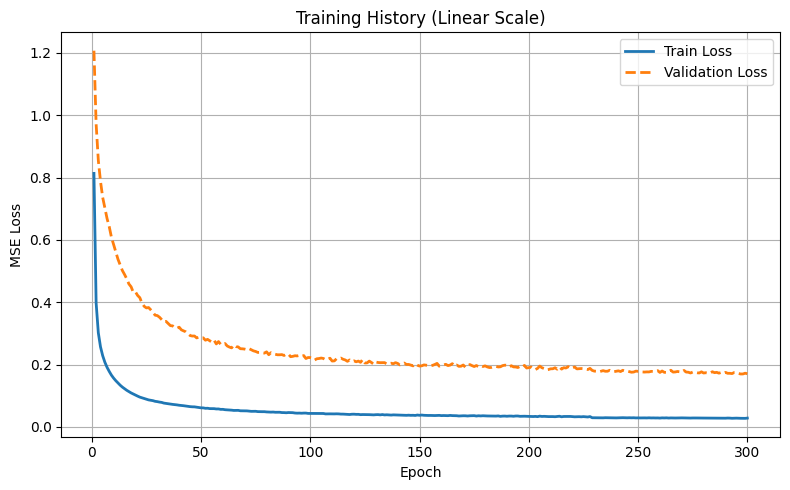

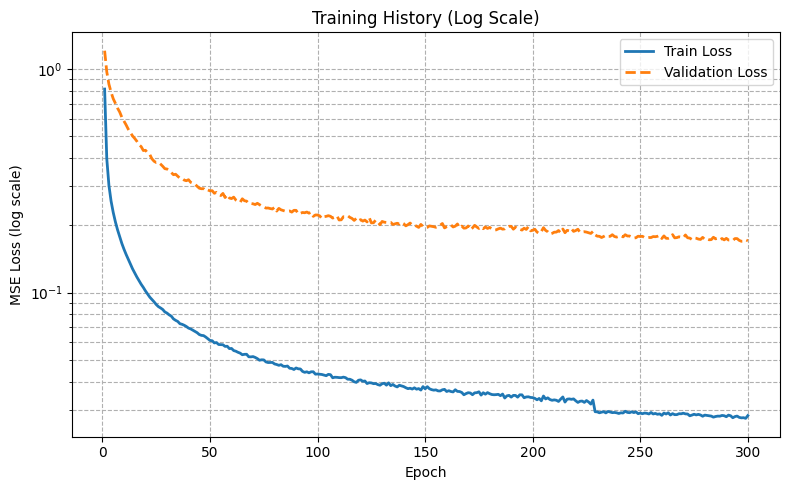

📈 Saved training history plots to checkpoints/


In [2]:
# ============================================
# 6️⃣  Plot full training history
# ============================================

# Convert to arrays
loss = np.array(history_all['loss'])
val_loss = np.array(history_all['val_loss'])
epochs = np.arange(1, len(loss) + 1)

# Linear-scale plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label="Train Loss", linewidth=2)
plt.plot(epochs, val_loss, label="Validation Loss", linewidth=2, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training History (Linear Scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "training_history_linear.png"), dpi=150)
plt.show()

# Log-scale plot (often clearer for convergence)
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label="Train Loss", linewidth=2)
plt.plot(epochs, val_loss, label="Validation Loss", linewidth=2, linestyle="--")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log scale)")
plt.title("Training History (Log Scale)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "training_history_log.png"), dpi=150)
plt.show()

print(f"📈 Saved training history plots to {save_dir}/")


✅ Loaded model from: checkpoints/model_epoch_300.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.005185  0.072008  0.029437  0.954051

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000530   0.000322   0.976371
Linear Velocity   0.000028   0.005300   0.003649   0.962705
         Angles   0.000023   0.004750   0.003176   0.980790
  Angular Rates   0.020689   0.143838   0.110602   0.896338


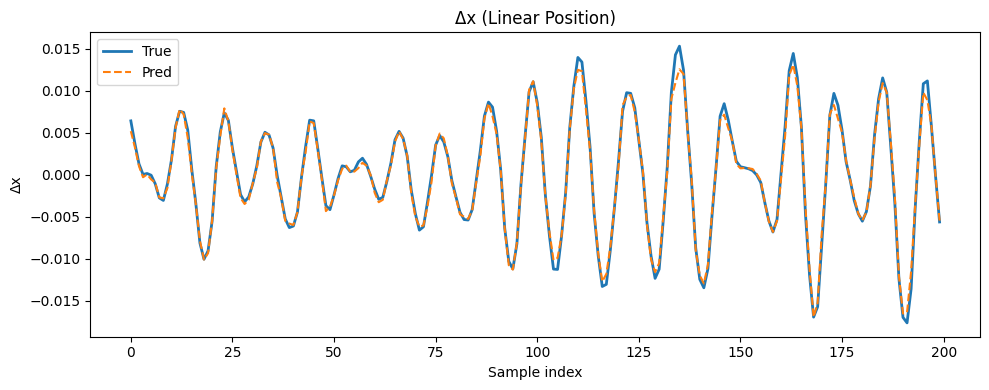

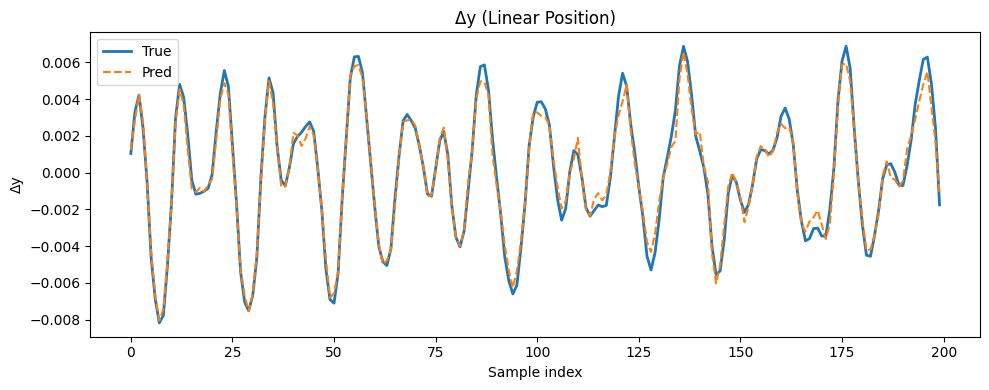

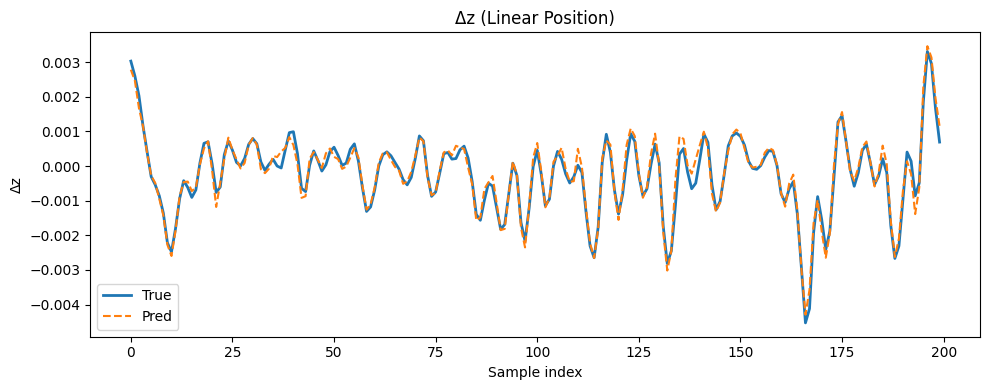

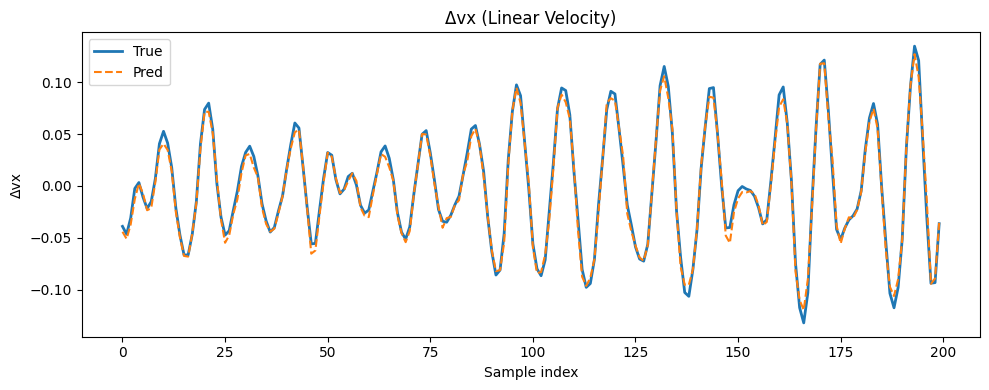

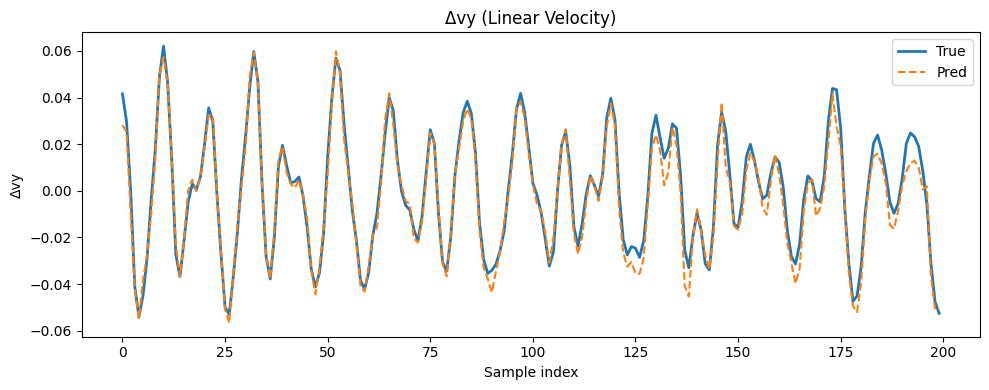

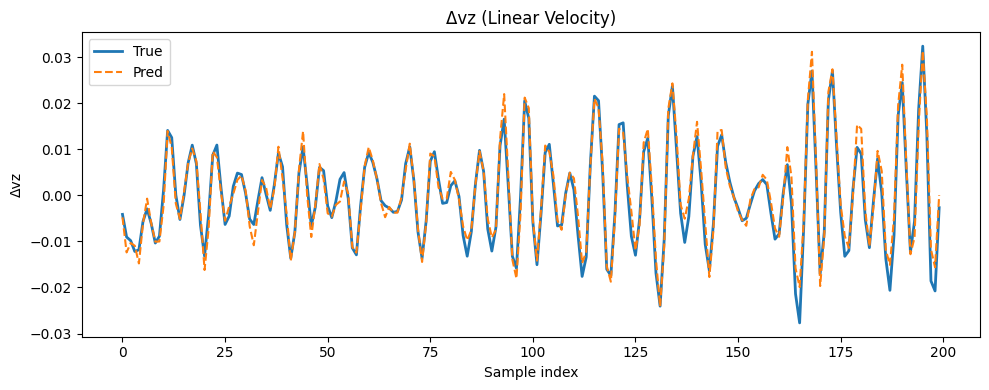

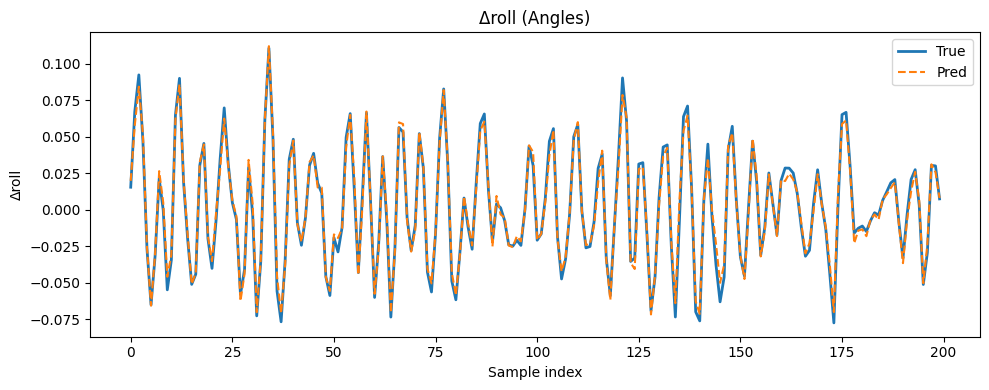

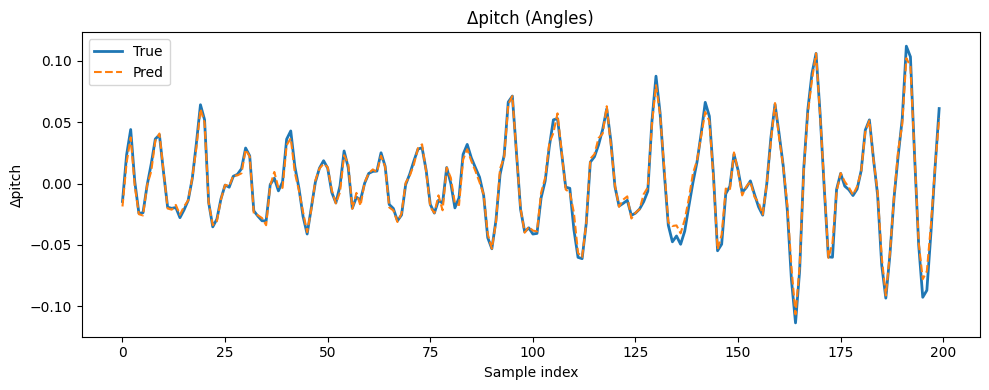

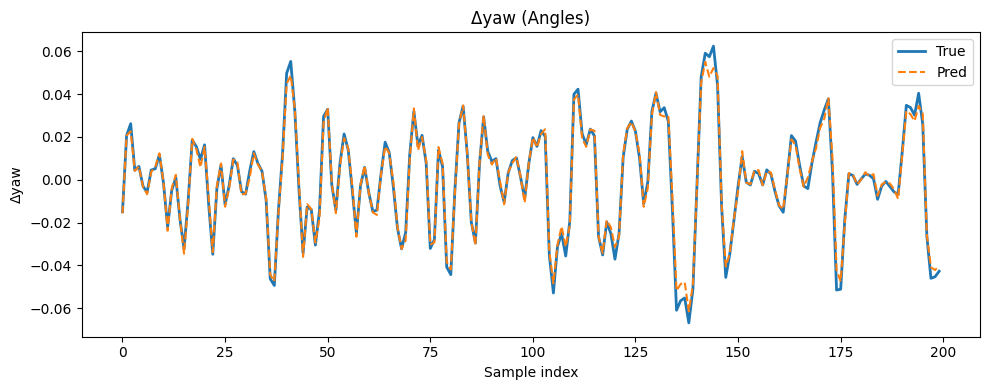

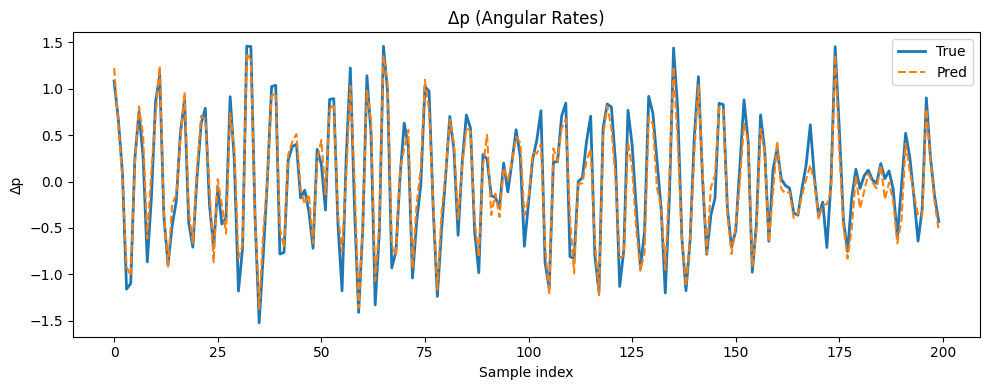

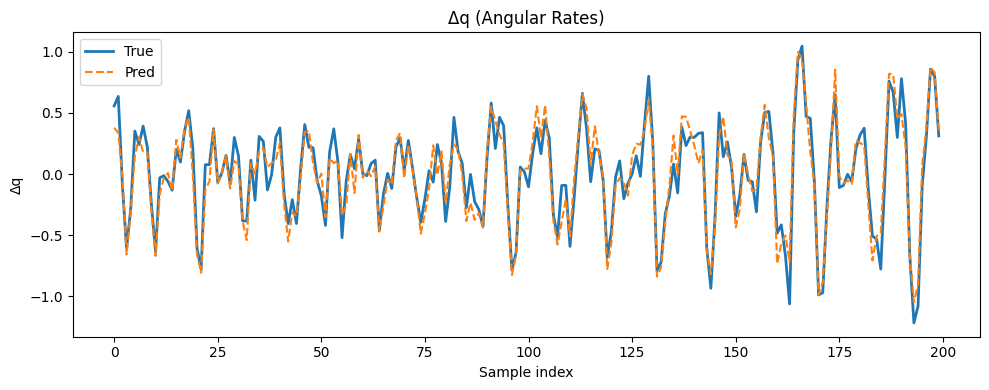

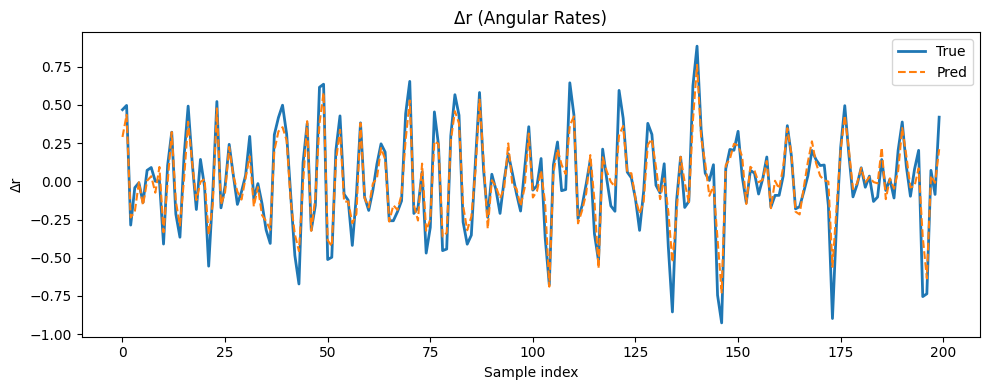


📊 Summary of Test Metrics:
             Group           MSE      RMSE       MAE        R2
0  Linear Position  2.804748e-07  0.000530  0.000322  0.976371
1  Linear Velocity  2.809410e-05  0.005300  0.003649  0.962705
2           Angles  2.256424e-05  0.004750  0.003176  0.980790
3    Angular Rates  2.068939e-02  0.143838  0.110602  0.896338


In [3]:
# ============================================
#   Evaluate final/best model with grouped metrics
# ============================================

from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

def test_keras_model_grouped(model_path, X_test, Y_test, sc_out, plot_dim=12):
    """
    Evaluate a saved Keras model and show grouped metrics + plots.
    """
    # --- Load model ---
    model = load_model(model_path)
    print(f"\n✅ Loaded model from: {model_path}")

    # --- Predict ---
    Y_pred = model.predict(X_test, verbose=0)

    # --- Denormalize predictions and ground truth ---
    Y_pred_phys = sc_out.inverse_transform(Y_pred)
    Y_true_phys = sc_out.inverse_transform(Y_test)

    # --- Overall metrics ---
    mse = mean_squared_error(Y_true_phys, Y_pred_phys)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_true_phys, Y_pred_phys)
    r2 = r2_score(Y_true_phys, Y_pred_phys)
    print("\n--- Overall Test Metrics ---")
    print(pd.DataFrame([{"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}]))

    # --- Grouped metrics ---
    var_names = ["Δx", "Δy", "Δz",
                 "Δvx", "Δvy", "Δvz",
                 "Δroll", "Δpitch", "Δyaw",
                 "Δp", "Δq", "Δr"]
    group_names = ["Linear Position", "Linear Velocity", "Angles", "Angular Rates"]

    group_metrics = []
    for g in range(4):
        start, end = g * 3, (g + 1) * 3
        Yt_g, Yp_g = Y_true_phys[:, start:end], Y_pred_phys[:, start:end]
        mse_g = mean_squared_error(Yt_g, Yp_g)
        rmse_g = np.sqrt(mse_g)
        mae_g = mean_absolute_error(Yt_g, Yp_g)
        r2_g = r2_score(Yt_g, Yp_g)
        group_metrics.append([group_names[g], mse_g, rmse_g, mae_g, r2_g])

    df_groups = pd.DataFrame(group_metrics, columns=["Group", "MSE", "RMSE", "MAE", "R2"])
    print("\n--- Metrics by Group ---")
    print(df_groups.to_string(index=False, justify="center", float_format=lambda x: f"{x:10.6f}"))

    # --- Optional per-dimension plots ---
    n_plots = min(plot_dim, Y_true_phys.shape[1])
    for i in range(n_plots):
        plt.figure(figsize=(10, 4))
        plt.plot(Y_true_phys[:200, i], label='True', linewidth=2)
        plt.plot(Y_pred_phys[:200, i], label='Pred', linestyle='--')
        plt.title(f"{var_names[i]} ({group_names[i//3]})")
        plt.xlabel("Sample index")
        plt.ylabel(var_names[i])
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"overall": {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2},
            "groups": df_groups}


# Evaluate the last saved model (or pick any from your checkpoints)
last_model_path = f"{save_dir}/model_epoch_{total_epochs}.keras"

results = test_keras_model_grouped(
    model_path=last_model_path,
    X_test=X_test,
    Y_test=Y_test,
    sc_out=sc_out,
    plot_dim=12  # number of outputs to plot
)

# Print summary table
print("\n📊 Summary of Test Metrics:")
print(results["groups"])

Plot limited to first 2.000s (200 samples).


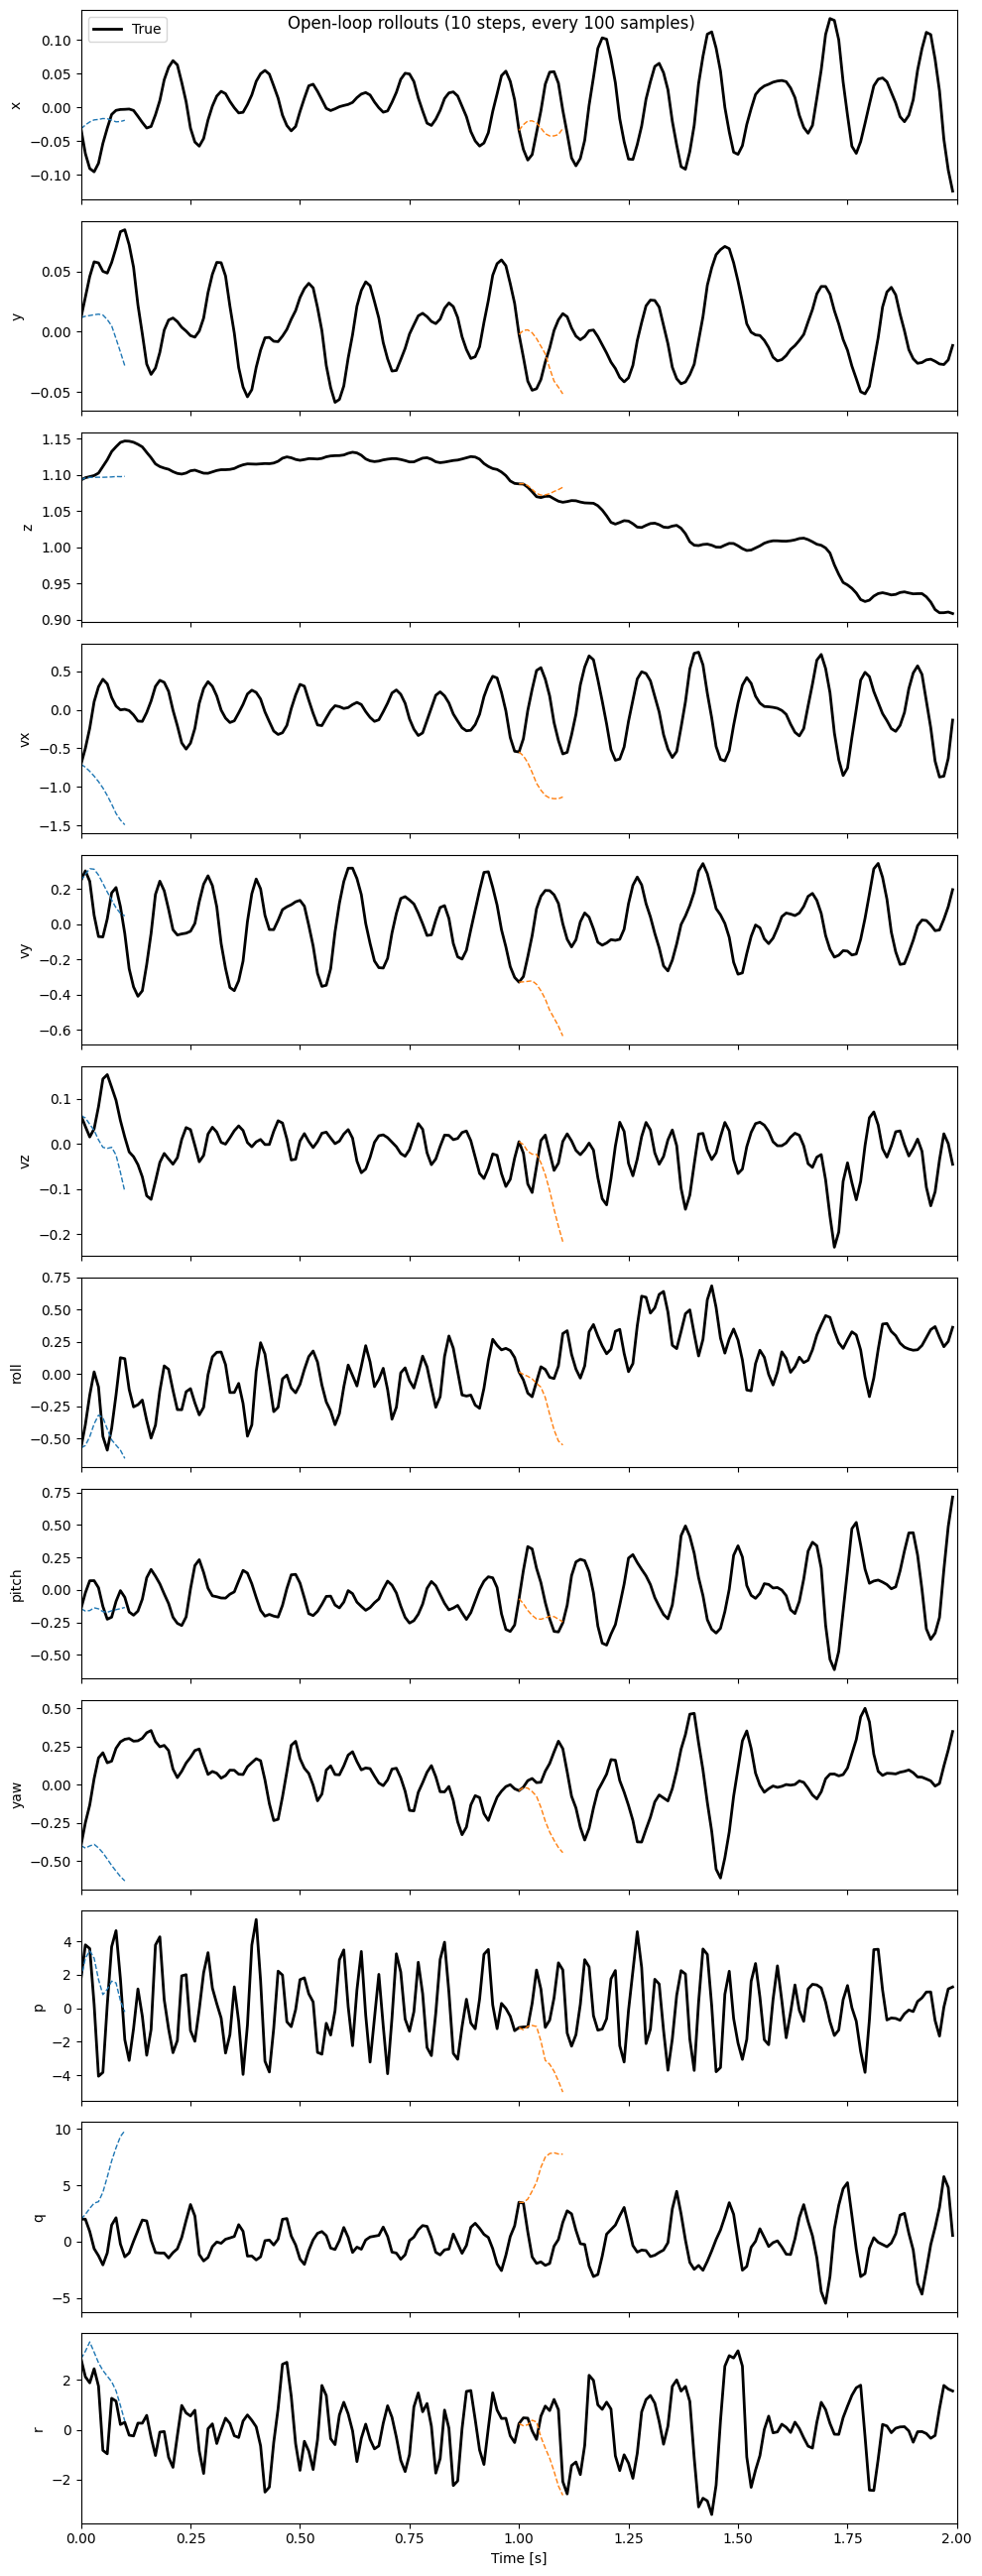


--- Open-loop horizon metrics (physical units) ---
MSE:  9.327031e+00
RMSE: 3.054019e+00
MAE:  1.398146e+00
R2:   -297.285237


In [8]:
# FOR SURE HERE THERE IS SOMETHING WRONG...


def inv_transform_cols(sc, Xn_part, col_start):
    """Inverse-transform selected columns from a fitted StandardScaler."""
    cols = slice(col_start, col_start + Xn_part.shape[1])
    return Xn_part * sc.scale_[cols] + sc.mean_[cols]

def transform_cols(sc, X_part, col_start):
    """Transform selected columns using the fitted StandardScaler."""
    cols = slice(col_start, col_start + X_part.shape[1])
    return (X_part - sc.mean_[cols]) / sc.scale_[cols]

def get_test_states_inputs_physical(X_test, sc_in, n_x):
    """
    From normalized X_test = [X_n, U_n], recover physical X_test_state and U_test.
    """
    Xn_state = X_test[:, :n_x]
    Xn_input = X_test[:, n_x:]
    X_state_phys = inv_transform_cols(sc_in, Xn_state, 0)
    U_phys       = inv_transform_cols(sc_in, Xn_input, n_x)
    return X_state_phys, U_phys

def rollout_openloop_model(
    model, X_test, sc_in, sc_out,
    n_x, n_u, dt=0.01, N_pred=5, stride=50,
    state_labels=None, plot_dim=None, max_plot_pts=200,
    t_max=None    # ← max time (in seconds) to display
):
    """
    Open-loop rollout on the TEST set (no shuffling), consistent with training:
    - keeps x in physical units,
    - builds normalized input with sc_in,
    - predicts Δx in normalized units, denormalizes with sc_out,
    - updates x_phys += Δx_phys,
    - optionally limits plots to t_max seconds (x-axis in real time).
    """

    # --- Denormalize test states and inputs ---
    X_phys, U_phys = get_test_states_inputs_physical(X_test, sc_in, n_x)
    N = len(X_phys)

    if state_labels is None:
        state_labels = [f"x{i+1}" for i in range(n_x)]
    if plot_dim is None:
        plot_dim = n_x

    # --- Build time vector ---
    t = np.arange(N) * dt

    # --- Optional limit for plotting only ---
    if t_max is not None:
        max_idx = np.searchsorted(t, t_max)
        X_phys = X_phys[:max_idx]
        U_phys = U_phys[:max_idx]
        t = t[:max_idx]
        N = len(X_phys)
        print(f"Plot limited to first {t_max:.3f}s ({N} samples).")

    # --- Plot true trajectories ---
    fig, axes = plt.subplots(n_x, 1, figsize=(10, 2.2 * n_x), sharex=True)
    if n_x == 1:
        axes = [axes]

    for i in range(n_x):
        axes[i].plot(t, X_phys[:, i], "k-", lw=2, label="True")
        axes[i].set_ylabel(state_labels[i])

    # --- Perform rollouts ---
    for k0 in range(0, N - N_pred, stride):
        x_phys = X_phys[k0].copy()
        traj_pred = [x_phys.copy()]

        for k in range(N_pred):
            if k0 + k >= N:
                break
            u_phys = U_phys[k0 + k]

            # Build normalized input [x,u]
            x_n = transform_cols(sc_in, x_phys.reshape(1, -1), 0).ravel()
            u_n = transform_cols(sc_in, u_phys.reshape(1, -1), n_x).ravel()
            inp_n = np.concatenate([x_n, u_n], axis=0).reshape(1, -1)

            # Predict Δx and update physical state
            delta_x_n = model.predict(inp_n, verbose=0)
            delta_x_phys = delta_x_n * sc_out.scale_ + sc_out.mean_
            x_phys = x_phys + delta_x_phys.ravel()
            traj_pred.append(x_phys.copy())

        traj_pred = np.array(traj_pred)
        t_pred = t[k0 : k0 + len(traj_pred)]

        for i in range(min(plot_dim, n_x)):
            axes[i].plot(
                t_pred[:max_plot_pts],
                traj_pred[:max_plot_pts, i],
                "--", lw=1
            )

    # --- Axis labels, limits, and formatting ---
    axes[-1].set_xlabel("Time [s]")
    for ax in axes:
        if t_max is not None:
            ax.set_xlim(0, t_max)
    axes[0].legend()

    fig.suptitle(f"Open-loop rollouts ({N_pred} steps, every {stride} samples)")
    plt.tight_layout()
    plt.show()

    # --- Metrics computation (unchanged) ---
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    Y_true_list, Y_pred_list = [], []
    for k0 in range(0, N - N_pred, stride):
        x_pred = X_phys[k0].copy()
        for k in range(N_pred):
            if k0 + k >= N:
                break
            u_phys = U_phys[k0 + k]
            x_n = transform_cols(sc_in, x_pred.reshape(1, -1), 0).ravel()
            u_n = transform_cols(sc_in, u_phys.reshape(1, -1), n_x).ravel()
            inp_n = np.concatenate([x_n, u_n], axis=0).reshape(1, -1)
            delta_x_n = model.predict(inp_n, verbose=0)
            delta_x_phys = delta_x_n * sc_out.scale_ + sc_out.mean_
            x_pred = x_pred + delta_x_phys.ravel()
        Y_pred_list.append(x_pred)
        Y_true_list.append(X_phys[k0 + N_pred])

    if Y_true_list:
        Y_true = np.vstack(Y_true_list)
        Y_pred = np.vstack(Y_pred_list)

        mse = mean_squared_error(Y_true, Y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(Y_true, Y_pred)
        r2 = r2_score(Y_true, Y_pred)

        print("\n--- Open-loop horizon metrics (physical units) ---")
        print(f"MSE:  {mse:.6e}")
        print(f"RMSE: {rmse:.6e}")
        print(f"MAE:  {mae:.6e}")
        print(f"R2:   {r2:.6f}")

        return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}
    else:
        print("Not enough samples to compute horizon metrics.")
        return None


n_x = Y_test.shape[1]
n_u = X_test.shape[1] - n_x

metrics = rollout_openloop_model(
    model=load_model(model_path),
    X_test=X_test,
    sc_in=sc_in,
    sc_out=sc_out,
    n_x=n_x,
    n_u=n_u,
    dt=0.01,
    N_pred=10,
    stride=100,
    t_max=2.0,   # <-- plot only first 2 seconds
    state_labels=["x","y","z","vx","vy","vz","roll","pitch","yaw","p","q","r"],
    plot_dim=12
)
